In [53]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, fsolve

assume normal distribution

96.56–104.97% (90% CI) AUC

81.68–95.13% (90% CI) geometric mean cipro/androcur

mean androcur=175ng/mL

mean ciproterone=150ng/mL

80-125% (90% CI) Cmax 

Cmax androcur calculations: 

ratio mu=0.88405,sigma=0.04088551

geom mean cipro,androcur: 162.019

In [54]:
def exp_cpa_decay(conc):
    if conc>100:
        return conc*0.5**(1/np.random.normal(loc=8,scale=1))
    elif conc>50:
        return conc*0.5**(1/np.random.normal(loc=32,scale=3))
    elif conc>20:
        return conc*0.5**(1/np.random.normal(loc=60,scale=12))
    else:
        return conc*0.8**(1/np.random.normal(loc=96,scale=24))

0.38611281679128745 0.9070847901100123


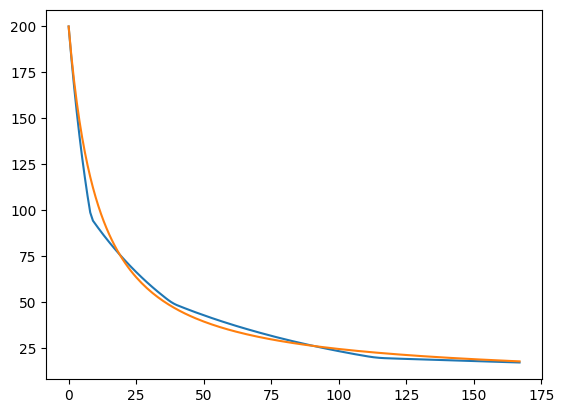

0.36321967377979403 0.9192575999636725


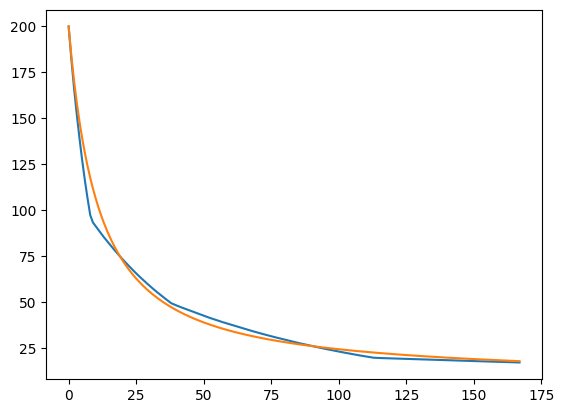

0.4140611379274386 0.8930452011550465


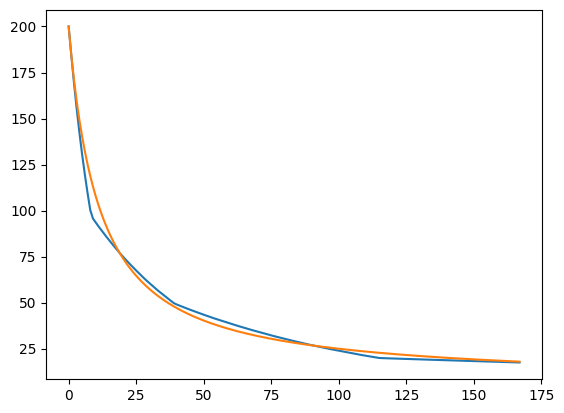

In [55]:
#checking cpa_decay
def testfunc(x,a,b):
    return 200*0.5**(x/(a*x**b+8))
    
lm=[]
for i in range(1000):
    l=[200]
    for j in range(167):
        l.append(exp_cpa_decay(l[-1]))
    lm.append(l.copy())
lmm=np.mean(np.array(lm),axis=0)
popt,_=curve_fit(testfunc,np.arange(168),lmm)
plt.plot(np.arange(168),lmm)
a,b=popt
print(a,b)
plt.plot(np.arange(168),testfunc(np.arange(168),a,b))
plt.show()

lm32=np.percentile(np.array(lm),32,axis=0)
popt,_=curve_fit(testfunc,np.arange(168),lm32)
plt.plot(np.arange(168),lm32)
a,b=popt
print(a,b)
plt.plot(np.arange(168),testfunc(np.arange(168),a,b))
plt.show()

lm68=np.percentile(np.array(lm),68,axis=0)
popt,_=curve_fit(testfunc,np.arange(168),lm68)
plt.plot(np.arange(168),lm68)
a,b=popt
print(a,b)
plt.plot(np.arange(168),testfunc(np.arange(168),a,b))
plt.show()

In [56]:
#fit function of d[cpa]/dt against [cpa]
def function(x,xx):
    a=0.386+0.0272*xx #fitted from piecewise function of exponentials, estimated std
    b=0.907-0.0141*xx
    return 200*0.5**(x/(a*x**b+8))

xs=np.arange(1,200,1)
xxs=np.arange(-2,2.01,0.01)

res=np.zeros((xs.shape[0],xxs.shape[0]))

for j,xx_value in enumerate(xxs):
    def diff(x,a):
        return (function(x,xx_value)-a)**2
    for i,x_value in enumerate(xs):
        res[i,j]=fsolve(diff, np.array(1.0), args=(x_value), xtol=1e-11, maxfev=2000)
np.save('inverseLUT.npy',res)

C:\Users\reiner\AppData\Local\Temp\ipykernel_7080\1482477068.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[i,j]=fsolve(diff, np.array(1.0), args=(x_value), xtol=1e-11, maxfev=2000)
c:\Users\reiner\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [57]:
res=np.load('inverseLUT.npy')

In [58]:
res[100-1,200] #checking against https://www.desmos.com/calculator/roq7rjmjkp

11.551369578692753

In [59]:
def cpa_decay(conc):
    xx=np.clip(np.random.normal(),-1,1)
    ctime=np.interp([conc],np.arange(1,200,1),res[:,np.round(xx*100).astype(int)+200])[0]
    return function(ctime+1,xx)

In [60]:
def cpa_metabolite(cpa_arr):
    r = [0]
    for i in range(1,len(cpa_arr)):
        delta_cpa=max(cpa_arr[i-1]-cpa_arr[i],0)
        const = math.log(.5)/24/3
        def drdt(cpa_m):
            #t is in [0,1]
            return cpa_m*const+delta_cpa
        r1=drdt(r[-1]) #RK4
        r2=drdt(r[-1]+r1*0.5)
        r3=drdt(r[-1]+r2*0.5)
        r4=drdt(r[-1]+r3)
        r.append(r[-1]+(r1+r2*2+r3*2+r4)/6)
    return r

conservative estimate of unsafe dosage: 25mg/day

min,max,mean: (37.26690717169299, 107.7282828387695, 72.4945087102889)

comparison for side effects: intolerable for first 12h at 37.5mg

56.44ng/ml (97.5% confident that intolerable conc. was at least this)

In [61]:
def simulate(dose,intervals,plot=True):
    repeat=sum(intervals)
    for i in range(len(intervals)-1,0,-1):
        intervals[i]=sum(intervals[:i+1])
    l=[dose/100*162.019/np.random.normal(loc=0.88405,scale=0.0408851)**0.5]
    for i in range(repeat*5):
        l.append(cpa_decay(l[-1]))
        if (i%repeat)+1 in intervals:
            l[-1]+=dose/100*162.019/np.random.normal(loc=0.88405,scale=0.0408851)**0.5
    if plot:
        plt.plot(np.arange(repeat*5+1)/24,l,'r',alpha=0.01)
    
    return [min(l),max(l),np.mean(l)],l

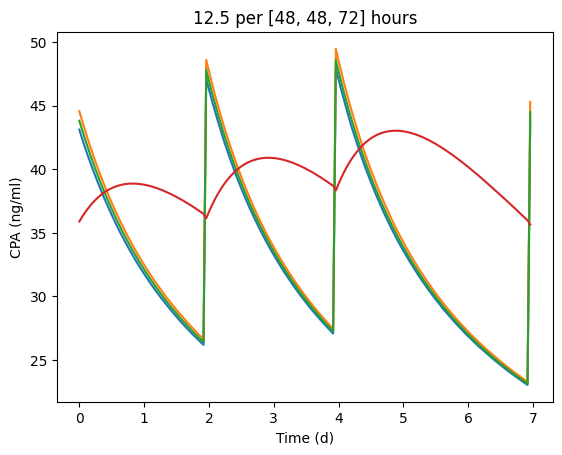

16.229425396663196 50.550833301986884 32.2246276667764


In [62]:
def check(dose,intervals,steady=False):
    r=sum(intervals)
    checker=[]
    for i in range(100):
        m,l=simulate(dose,intervals.copy(),plot=(not steady))
        checker.append(l)
    if steady:
        plt.plot(np.arange(r)/24,np.percentile(checker,5,axis=0)[-r:])
        plt.plot(np.arange(r)/24,np.percentile(checker,95,axis=0)[-r:])
        plt.plot(np.arange(r)/24,np.mean(checker,axis=0)[-r:])
        plt.plot(np.arange(r)/24,cpa_metabolite(np.mean(checker,axis=0))[-r:])
    plt.xlabel('Time (d)')
    plt.ylabel('CPA (ng/ml)')
    plt.title(str(dose)+' per '+str(intervals)+' hours')
    plt.show()
    print(np.min(checker),np.max(checker),np.mean(checker))
    return np.mean(checker,axis=0)[-r:]
cpa_levels = check(12.5,[48,48,72],steady=True)

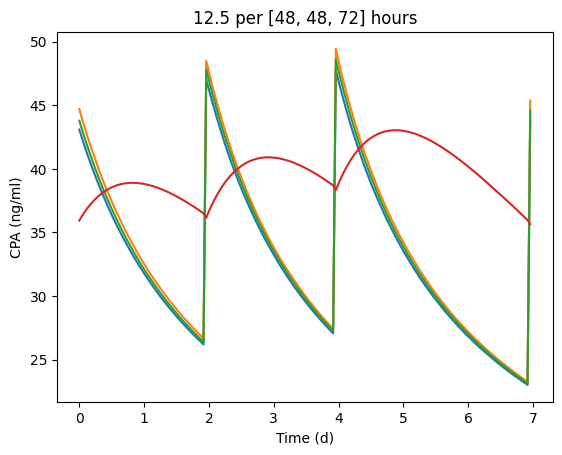

16.66849436805994 50.118028712625346 32.22826103883139


array([43.78723847, 43.08804829, 42.4139481 , 41.76691104, 41.1419706 ,
       40.53847154, 39.95670272, 39.39555502, 38.85258924, 38.3273092 ,
       37.81780472, 37.32462203, 36.84698122, 36.38434067, 35.93547942,
       35.50068627, 35.07794583, 34.66781706, 34.26939544, 33.8824108 ,
       33.50611442, 33.13893965, 32.78268143, 32.43521614, 32.09615458,
       31.76860001, 31.44766163, 31.13326948, 30.83009765, 30.53283152,
       30.24061796, 29.95761757, 29.68230476, 29.41066285, 29.14438815,
       28.88793565, 28.6370407 , 28.38780421, 28.14423096, 27.90987175,
       27.68062673, 27.45251107, 27.22780256, 27.01090431, 26.80125827,
       26.59287567, 26.38510879, 47.80088502, 46.94539137, 46.12397436,
       45.33690098, 44.58004683, 43.85243148, 43.15212037, 42.4769314 ,
       41.82557033, 41.19782286, 40.59310507, 40.00819814, 39.44516705,
       38.89793545, 38.37099028, 37.86093838, 37.36766895, 36.88817232,
       36.4238136 , 35.97378547, 35.53885585, 35.11330353, 34.70

In [63]:
#25 every 3-4 days, side effects ;-;
#check(25,[72,96],steady=True)

#25/week, too variable
#check(25,[7*24],steady=True)

#12.5/3-4 days?
#check(12.5,[72,96],steady=True)

#12.5/2-3 days (current)
check(12.5,[48,48,72],steady=True)

14.219999999999999


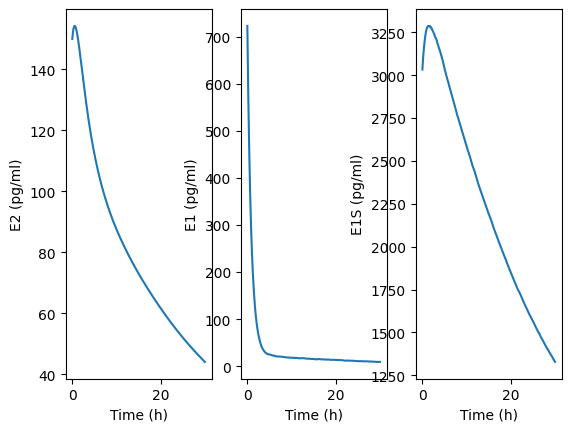

In [64]:
# e2, e1, e1 sulfate
e = [np.array([150,723,3033])] #150pg/ml peak for single dose 2mg
dt=.03
def est_rk4(e, dt):
    # conversion 15%, 65% e2, 5%, 54% e1, 1.4%, 21% e1 sulfate
    # clearance 20% e2, 41% e1, 77.6% e1 sulfate
    ma, mb, mc = 272.4, 270.366, 350.429
    randc3 = np.random.beta(2,5)
    c1,c3=7.52e-2, 1e-2**randc3*4e-2**(1-randc3)
    c12, c13 = c1/2*1.5, c1/2*6.5
    c32=c3/77.6*21
    c32b=c32/mc*mb
    c31=c13*4.5e-2/ma*mc#c3/77.6*1.4
    c21a=c12
    c21=c21a/ma*mb
    c23, c2 = c21/5*54, c21/5*41
    c12b,c13c,c23c,c31a = c12/ma*mb, c13/ma*mc, c23/mb*mc, c31/mc*ma
    def deltaest(e):
        return np.array([[-c1-c12-c13,c21a,c31a],[c12b,-c2-c21-c23,c32b],[c13c,c23c,-c3-c31-c32]])@e
    v1 = deltaest(e)
    v2 = deltaest(e+dt/2*v1)
    v3 = deltaest(e+dt/2*v2)
    v4 = deltaest(e+dt*v3)
    return e+dt*(v1+2*(v2+v3)+v4)/6

for i in range(1000):
    new = est_rk4(e[-1], dt)
    if (new[0]-75)*(e[-1][0]-75)<0:
        print(i*dt)
    e.append(new)
f,ax=plt.subplots(1,3)
e=np.array(e).T
t=np.arange(1001)*dt
ax[0].plot(t,e[0]);ax[1].plot(t,e[1]);ax[2].plot(t,e[2])
ax[0].set_xlabel('Time (h)')
ax[0].set_ylabel('E2 (pg/ml)')
ax[1].set_xlabel('Time (h)')
ax[1].set_ylabel('E1 (pg/ml)')
ax[2].set_xlabel('Time (h)')
ax[2].set_ylabel('E1S (pg/ml)')
plt.show()


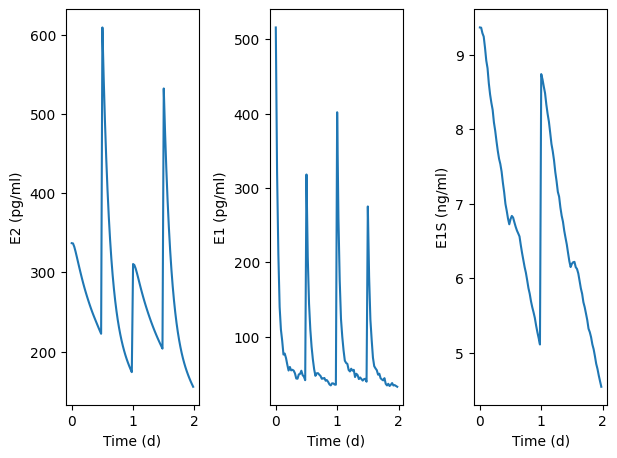

In [65]:
def simulate_est(doseoral, dosesl, interval, repetitions, gap=0.5, plot=True):
    dt=0.5
    dose1 = np.array([150,723,3033])*doseoral*np.clip(np.random.normal(1,0.1),0.8,1.5)/2
    e = [dose1]
    time = int(interval/dt*repetitions)
    for i in range(1,time):
        if i%int(interval/dt)==0:
            dose1 = np.array([75,359,2015])*doseoral*np.clip(np.random.normal(1,0.1),0.8,1.5)
            e.append(est_rk4(e[-1]+dose1,dt))
        elif i%int(interval/dt)==int(interval/dt*gap):
            dose2 = dosesl*np.array([0.5,0.5,0])*np.clip(np.random.normal(420,30),350,490)
            e.append(est_rk4(e[-1]+dose2,dt))
        else: e.append(est_rk4(e[-1],dt))
    
    e=np.array(e)[-int(24*2/dt):].T
    if plot:
        f,ax=plt.subplots(1,3)
        f.tight_layout(pad=2)
        time=np.arange(int(24*2/dt))*dt/24
        ax[0].plot(time,e[0]);ax[1].plot(time,e[1]);ax[2].plot(time,e[2]/1000)
        ax[0].set_xlabel('Time (d)')
        ax[0].set_ylabel('E2 (pg/ml)')
        ax[1].set_xlabel('Time (d)')
        ax[1].set_ylabel('E1 (pg/ml)')
        ax[2].set_xlabel('Time (d)')
        ax[2].set_ylabel('E1S (ng/ml)')
        plt.show()
    return e[0]
#simulate_est(0,1,4,100)
e2 = simulate_est(2,2,24,14)

# gaps = np.linspace(0.1,0.9,50)
# bioavail = [np.mean(simulate_est(2,2,24,14,gap=gap, plot=False)) for gap in gaps] # arbitrary units
# plt.plot(gaps,bioavail)


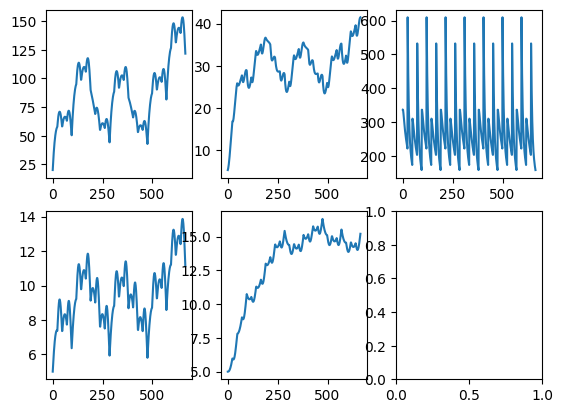

In [71]:
SPRE = 1
def Papp_hill(p4,e2):
    return p4/2*(1+e2**8/(75**8+e2**8))

def deltarpLH(e2,p4,rpLH): # iu/day
    Papp = Papp_hill(p4,e2)
    return (500+4500*e2**8/(175**8+e2**8))/(1+Papp/12.2)-(2.42*(1+0.26*Papp)*rpLH)/(1+0.004*e2) #t not added
def deltaLH(e2,p4,rpLH,LH):
    Papp = Papp_hill(p4,e2)
    return 1/2.5*2.42*(1+0.26*Papp)*rpLH/(1+0.004*e2)-14*LH
def deltarpFSH(e2,p4,rpFSH,InhA): # InhA of 2 days before
    Papp = Papp_hill(p4,e2)
    return 375/(1+InhA)/1.75-1.9*(1+12*Papp)*rpFSH/(1+0.0018*e2**2)
def deltaFSH(e2,p4,rpFSH,FSH):
    Papp = Papp_hill(p4,e2)
    return 1/2.5*1.9*(1+12*Papp)*rpFSH/(1+0.0018*e2**2)-2*FSH # TODO: clearance term unknown

def rk4LH(e20, e21, p4,rpLH,LH,dt=0.1/24):
    e2mid = (e20+e21)/2
    rpLH1 = deltarpLH(e20,p4,rpLH)
    LH1 = deltaLH(e20,p4,rpLH,LH)
    rpLH2 = deltarpLH(e2mid,p4,rpLH+rpLH1*dt/2)
    LH2 = deltaLH(e2mid,p4,rpLH+rpLH1*dt/2,LH+LH1*dt/2)
    rpLH3 = deltarpLH(e2mid,p4,rpLH+rpLH2*dt/2)
    LH3 = deltaLH(e2mid,p4,rpLH+rpLH2*dt/2,LH+LH2*dt/2)
    rpLH4 = deltarpLH(e21,p4,rpLH+rpLH3*dt)
    LH4 = deltaLH(e21,p4,rpLH+rpLH3*dt,LH+LH3*dt)
    return rpLH+(rpLH1+2*(rpLH2+rpLH3)+rpLH4)*dt/6, LH+(LH1+2*(LH2+LH3)+LH4)*dt/6

def rk4FSH(e20, e21, p4,rpFSH, FSH, InhA, dt=0.1/24):
    e2mid = (e20+e21)/2
    rpFSH1 = deltarpFSH(e20,p4,rpFSH,InhA)
    FSH1 = deltaFSH(e20,p4,rpFSH,FSH)
    rpFSH2 = deltarpFSH(e2mid,p4,rpFSH+rpFSH1*dt/2,InhA)
    FSH2 = deltaFSH(e2mid,p4,rpFSH+rpFSH1*dt/2,FSH+FSH1*dt/2)
    rpFSH3 = deltarpFSH(e2mid,p4,rpFSH+rpFSH2*dt/2,InhA)
    FSH3 = deltaFSH(e2mid,p4,rpFSH+rpFSH2*dt/2,FSH+FSH2*dt/2)
    rpFSH4 = deltarpFSH(e21,p4,rpFSH+rpFSH3*dt,InhA)
    FSH4 = deltaFSH(e21,p4,rpFSH+rpFSH3*dt,FSH+FSH3*dt)
    return rpFSH+(rpFSH1+2*(rpFSH2+rpFSH3)+rpFSH4)*dt/6, FSH+(FSH1+2*(FSH2+FSH3)+FSH4)*dt/6

#e2=e2[int(e2.shape[0]/2):]
LH = [[20, 5.2]]
FSH = [[5,5]]
for p in range(7):
    for i in range(e2.shape[0]-1):
        p4 = cpa_levels[int(cpa_levels.shape[0]/7*p)]
        LH.append(rk4LH(e2[i], e2[i+1], p4, LH[-1][0], LH[-1][1]))
        FSH.append(rk4FSH(e2[i], e2[i+1], p4, FSH[-1][0], FSH[-1][1], 1.8))
LH = np.array(LH).T
FSH = np.array(FSH).T
t=np.arange(LH.shape[1])
f,ax = plt.subplots(2,3)
ax[0][0].plot(t,LH[0])
ax[0][1].plot(t,LH[1])
ax[0][2].plot(t[1:],np.tile(e2[:-1],7))
ax[1][0].plot(t,FSH[0])
ax[1][1].plot(t,FSH[1])
plt.show()